<a href="https://colab.research.google.com/github/Buyan-Kirill/practice-VTM-sem-8/blob/main/Tensors_task_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$\Large{Levenberg-Marquardt}$

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

errors = []
lambdas = []
iters = []

In [2]:
class LevenbergMarquardt:
    def __init__(self, T) -> None:
      self.T = T.copy()
      self.dimensions = self.T.shape
      self.len = len(self.dimensions)

    # Размеры тензора
    @property
    def shape(self):
        return self.dimensions

    # Размерность тензора
    def len(self):
        return self.len


    # Вспомогательная для get_W
    def get_W_col(self, layers, row, col):
        start_layer = row - 1
        middle_layer = col - row - 2 if row != col else None
        end_layer = self.len - col - 2

        if start_layer >= 0:
            W_col = layers[start_layer][0]
        else:
            W_col = None

        if middle_layer is not None and middle_layer >= 0:
            if W_col is not None:
                W_col = W_col * layers[middle_layer][row + 1]
            else:
                W_col = layers[middle_layer][row + 1]

        if end_layer >= 0:
            if W_col is not None:
                W_col = W_col * layers[end_layer][-1]
            else:
                W_col = layers[end_layer][-1]

        return W_col


    def get_W(self, layers):
        W = []
        for row in range(self.len):
            W_col = self.get_W_col(layers, row, row)
            W_row = [W_col]

            for col in range(row + 1, self.len):
                W_col = self.get_W_col(layers, row, col)
                W_row.append(W_col)

            W.append(W_row)
        return W

    # Вспомогательная для get_JT_J
    def fill_diagonal_blocks(self, JJ, W, pos, rank):
        for row in range(self.len):
            BB = W[row][0]
            for r in range(self.dimensions[row]):
                block_start = pos[row] + r * rank
                block_end = block_start + rank
                JJ[block_start:block_end, block_start:block_end] = BB

    # Вспомогательная для _fill_off_diagonal_blocks
    def fill_block_pair(self, JJ, W_block, alpha_pos, i_pos, betta_idx, j_idx, rank, alpha_core, i_core):
        alpha_block_start = alpha_pos + betta_idx * rank
        i_block_start = i_pos + j_idx * rank

        for gamma in range(rank):
            for k in range(rank):
                val = W_block[gamma][k] * i_core[gamma] * alpha_core[k]

                row = alpha_block_start + gamma
                col = i_block_start + k
                JJ[row, col] = val
                JJ[col, row] = W_block[k][gamma] * i_core[gamma] * alpha_core[k]

    # Вспомогательная для get_JT_J
    def fill_not_diagonal_blocks(self, JJ, W, pos, rank):
        for alpha in range(self.len):
            alpha_pos = pos[alpha]
            for i in range(alpha + 1, self.len):
                i_pos = pos[i]
                weight_matrix = W[alpha][i - alpha]

                for betta in range(self.dimensions[alpha]):
                    for j in range(self.dimensions[i]):
                        self.fill_block_pair(
                            JJ, weight_matrix,
                            alpha_pos, i_pos, betta, j, rank,
                            self.cores[alpha][betta], self.cores[i][j]
                        )


    def get_JT_J(self, W, pos, jacob_size, rank):
        JTJ = np.zeros((jacob_size, jacob_size))
        self.fill_diagonal_blocks(JTJ, W, pos, rank)
        self.fill_not_diagonal_blocks(JTJ, W, pos, rank)
        return JTJ


    def get_JA(self, rank, W, jacob_size):
        JA = np.zeros(jacob_size)

        for i in range(self.len):
            weight_matrix = W[i][0]
            start_position = int(np.sum(self.dimensions[:i]) * rank)

            for j in range(self.dimensions[i]):
                core_slice = self.cores[i][j]
                position = start_position + j * rank

                for k in range(rank):
                    JA[position + k] = np.sum(weight_matrix[k, :] * core_slice[:rank])

        return JA

    # Вспомогательная для get_JT
    def fill_last_mode(self, JT, start, end, rank):
        perm = [self.len - 1] + list(range(self.len - 1))
        dims_perm = [self.dimensions[-1]] + list(self.dimensions[:-1])
        Bi = []

        for r in range(rank):
            perm[0] = self.len - 1
            contracted = np.transpose(self.T, perm)

            for idx in range(self.len - 1, 0, -1):
                contracted = contracted.reshape(-1, dims_perm[idx]) @ self.cores[idx - 1][:, r]
                contracted = contracted.reshape(dims_perm[:idx])
                perm[0] -= 1

            Bi.append(contracted)

        JT[start:end] = np.vstack(Bi).T.reshape(-1)

    # Вспомогательная для get_JT
    def fill_middle_mode(self, JT, start, end, rank, back_contractions, mode):
        perm = [mode] + list(range(mode))
        dims = [self.dimensions[mode]] + list(self.dimensions[:mode])
        Bi = []

        for r in range(rank):
            tensor = back_contractions[self.len - 2 - mode][:, r]
            tensor = tensor.reshape(self.dimensions[:mode + 1])
            tensor = np.transpose(tensor, perm)

            for idx in range(mode - 1, -1, -1):
                tensor = tensor.reshape(-1, self.dimensions[idx]) @ self.cores[idx][:, r]
                tensor = tensor.reshape(dims[:idx + 1])
                perm[0] -= 1

            Bi.append(tensor)
            perm[0] = mode

        JT[start:end] = np.vstack(Bi).T.reshape(-1)

    # Вспомогательная для get_JT
    def fill_JT(self, JT, rank, back_contractions):
        for mode in range(self.len):
            start = int(np.sum(self.dimensions[:mode]) * rank)
            end = int(np.sum(self.dimensions[:mode + 1]) * rank)

            if mode == 0:
                JT[start:end] = back_contractions[-1].reshape(-1)
            elif mode == self.len - 1:
                self.fill_last_mode(JT, start, end, rank)
            else:
                self.fill_middle_mode(JT, start, end, rank, back_contractions, mode)

    # Вспомогательная для get_JT
    def compute_backward_contractions(self, rank, T_flat):
        back_contractions = []
        current = T_flat @ self.cores[-1][:, 0]

        for r in range(1, rank):
            current = np.vstack((current, T_flat @ self.cores[-1][:, r]))
        back_contractions.append(current.T)

        for step in range(1, self.len - 1):
            prev = back_contractions[step - 1]
            dim_idx = self.len - 1 - step

            temp = prev[:, 0].reshape(-1, self.dimensions[dim_idx]) @ self.cores[dim_idx][:, 0]
            for r in range(1, rank):
                vec = prev[:, r].reshape(-1, self.dimensions[dim_idx]) @ self.cores[dim_idx][:, r]
                temp = np.vstack((temp, vec))
            back_contractions.append(temp.T)

        return back_contractions

    def get_JT(self, rank, total_size):
        JT = np.zeros(total_size)
        T_flat = self.T.reshape(-1, self.dimensions[-1])
        back_contractions = self.compute_backward_contractions(rank, T_flat)
        self.fill_JT(JT, rank, back_contractions)
        return JT

    @property
    def layers_num(self):
        layers = []
        first_layer = [core.T @ core for core in self.cores]
        layers.append(first_layer)

        for n in range(1, self.len - 1):
            current_layer = [
                layers[n - 1][r] * layers[0][r + n]
                for r in range(self.len - n)
            ]
            layers.append(current_layer)

        return layers

    # Шаг оптимизации
    def optimizer(self, jacob_size, rank, pos, Lambda):
        layers = self.layers_num
        W = self.get_W(layers)
        JT_J = self.get_JT_J(W, pos, jacob_size, rank)
        JA = self.get_JA(rank, W, jacob_size)
        JT = self.get_JT(rank, jacob_size)

        b = JA.reshape((-1,)) - JT.reshape((-1,))

        D_s = np.sqrt(np.diag(JT_J))
        D_s_i = 1 / D_s

        b = D_s_i * b
        B = D_s_i.reshape((-1, 1)) * JT_J * D_s_i
        T, U = linalg.hessenberg(B, calc_q=True)

        b = U.T @ b

        new_T = T + Lambda * np.eye(jacob_size)
        y = linalg.solve(new_T, b, assume_a='her')
        delta = U @ y
        delta = D_s_i * delta

        return delta

    # Получить новые ядра тензора
    # delta - вектор, который нужно вычесть из текущих ядер
    def get_new_cores(self, delta, rank):
        new_cores = []
        for i in range(self.len):
            position = int(np.sum(self.dimensions[:i]) * rank)
            core = np.zeros((self.dimensions[i], rank))
            for j in range(self.dimensions[i]):
                core[j, :] = self.cores[i][j, :] - (delta[position + j * rank:position + (j+1)*rank]).reshape(-1,)
            new_cores.append(core)
        return new_cores

    # Получить ошибку аппроксимирования
    # rank - ранг тензора
    # cores - ядра тензора
    def get_approx_error(self, rank, cores):
        sweep_l = np.ones(rank).reshape(1, -1)
        for j in range(self.len):
            sweep_l = linalg.khatri_rao(sweep_l, cores[j])

        error = np.linalg.norm(np.sum(sweep_l, axis=1) - self.T.reshape(-1,)) / np.linalg.norm(self.T.reshape(-1,))
        return error


    # Получить аппрокисимацию тензора в каноническом формате
    # rank - ранг тензора
    # tol - точность
    # max_iter_num - максимальное количество итераций
    # Lambda - начальное значение для Левенберга-Маркуарда
    # Lambda_scale - коэффициент, на который умножается Лямбда при увеличении
    def Approximate(self, rank, seed=42, tol = 10**-9, max_iter_num = 100, Lambda = 1., Lambda_scale = 5.):

        jacob_size = int(np.sum(self.dimensions) * rank)

        np.random.seed(seed)
        self.cores = np.array([np.random.rand(self.dimensions[i], rank) for i in range(self.len)], dtype=object)

        pos = [0]
        for i in range(self.len - 1):
            pos.append(pos[i] + self.dimensions[i] * rank)

        error = self.get_approx_error(rank, self.cores)

        for it in range(max_iter_num):
            delta = self.optimizer(jacob_size, rank, pos, Lambda)

            new_cores = self.get_new_cores(delta, rank)
            cur_error = self.get_approx_error(rank, new_cores)

            if cur_error < error:
                self.cores = new_cores
                error = cur_error
                Lambda /= Lambda_scale
            else:
                Lambda *= Lambda_scale

            global errors, lambdas, iters
            errors.append(error)
            lambdas.append(Lambda)
            iters.append(it)
            # print(f'it={it}, last_error={error}, current_error={cur_error}, Lambda={Lambda}')

            if error < tol:
                print(f'Converged with error={error} in {it} iterations')
                break


        return self.cores

In [3]:
def plot_errors():
    global errors, lambdas, iters
    print()

    plt.plot(iters, errors, label='Errors')
    plt.xlabel('Iterations')
    plt.ylabel('Error')
    plt.yscale('log')
    plt.title('Errors over Iterations')
    plt.legend()
    plt.show()

    plt.plot(iters, lambdas, label='Lambdas')
    plt.xlabel('Iterations')
    plt.ylabel('Lambda')
    plt.yscale('log')
    plt.title('Lambdas over Iterations')
    plt.legend()
    plt.show()

    errors, lambdas, iters = [], [], []

In [4]:
def rank1_tensor(*vectors):
    return np.multiply.outer(vectors[0], vectors[1]) if len(vectors) == 2 else np.multiply.outer(rank1_tensor(*vectors[:-1]), vectors[-1])

u = np.random.random(3)
v = np.random.random(4)
w = np.random.random(5)

T = rank1_tensor(u, v, w)

errors, lambdas, iters = [], [], []
LM = LevenbergMarquardt(T)

Converged with error=9.146056895643017e-11 in 6 iterations



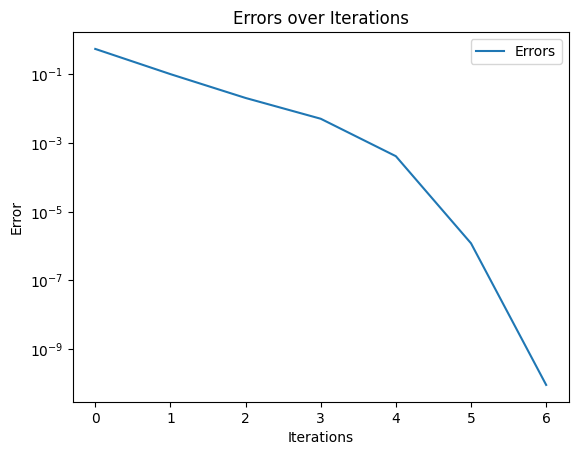

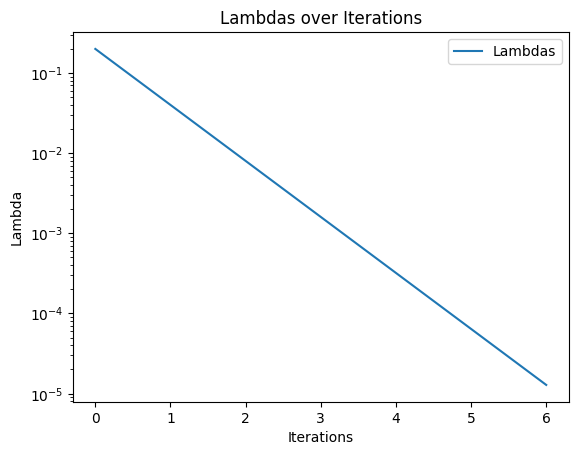

In [5]:
rank = 2
new_cores = LM.Approximate(rank)
plot_errors()

In [6]:
def f(i, j, k, l, s):
    return np.sin(i + j + k + l + s)

sizes = (9, 27, 13, 11, 8)
T = np.fromfunction(f, sizes)

errors, lambdas, iters = [], [], []
LM = LevenbergMarquardt(T)

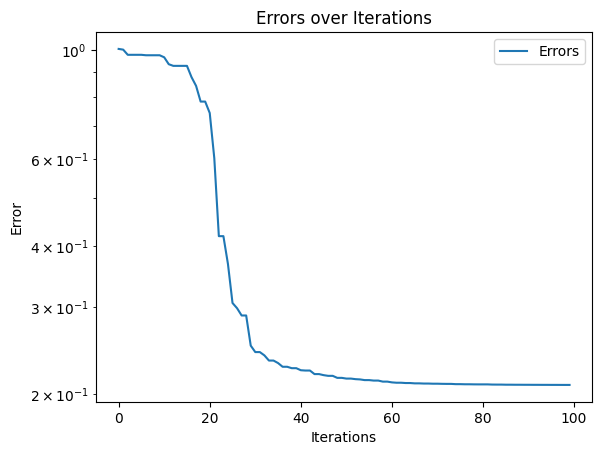

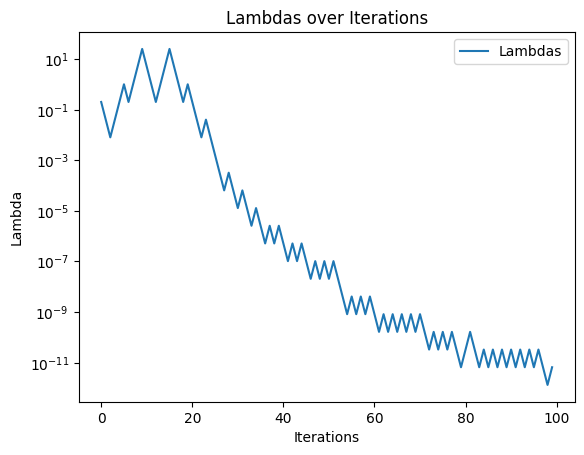

In [7]:
rank = 4
new_cores = LM.Approximate(rank)
plot_errors()

Converged with error=1.7401401501753976e-11 in 34 iterations



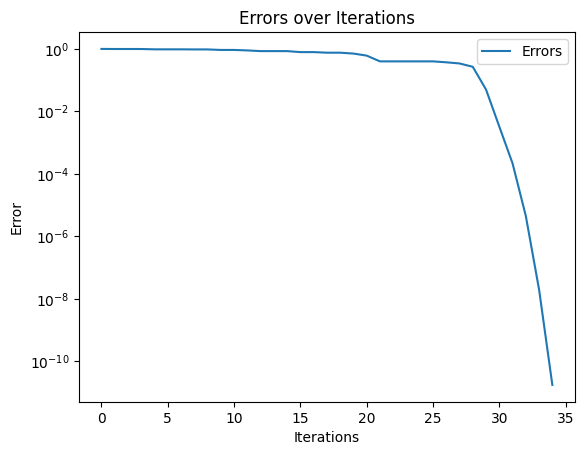

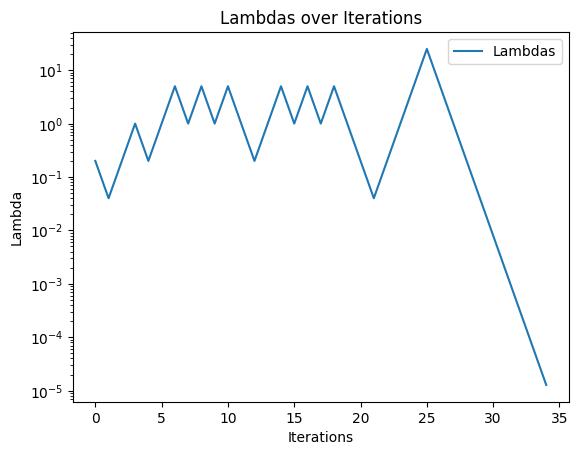

In [8]:
rank = 6
new_cores = LM.Approximate(rank)
plot_errors()